## Исследование новой системы поиска анкет в дейтинговом приложении через интерпритацию результатов А/B теста

###  Для проверки работы нового алгоритма для поиска наиболее подходящих анкет был проведен АБ-тест, в рамках которого все пользователи приложения были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

### Оценим, правда ли, что новый алгоритм улучшил качество сервиса и сделаем аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.

### ПЛАН РАБОТЫ:

**1. Прочитаем файл и сделаем предобработку данных** 

**2. Посмотрим на следующие метрики:**  
**- Соотношение мэтчей и не мэтчей в группах**  
**- Среднее число анкет на каждого пользователя**  
**- Среднее число мэтчей на каждого пользователя**  

**3. Ответим на вопрос: Был ли эксперимент успешен в целом и стоит ли включать новую систему поиска анкет на всех пользователей**  

**Механика приложения следующая:**  
**Пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки.**  
**Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться**  

**В dating_data.csv находится выгрузка логов взаимодействия пользователей друг с другом**   
**Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.  
Группу с номером 0, в которой пользователи, использующие приложение со старым алгоритмом, будем называть контрольная группа.  
Группу с номером 1, в которой пользователи, использующие приложение с новым алгоритмом для поиска анкет, будем называть тестовая группа** 

## 1. Прочитаем файл и сделаем предобработку данных

In [3]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import scipy.stats as st
import pingouin as pg
import numpy as np

In [4]:
# прочитаем наш датасет
df = pd.read_csv('dating_data.csv')
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [5]:
# посмотрим размер каждой группы
df.groupby('group').size()

# в тестовой группе данных в два раза больше чем в контрольной

group
0    4792
1    9722
dtype: int64

In [6]:
# посмотрим количестиво уникальных пользователей в каждой группе
df.groupby('group').user_id_1.nunique()

group
0    501
1    499
Name: user_id_1, dtype: int64

In [22]:
# проверим нет ли пересечения между группами пользователей
# когда пользователь попал и в контрольную группу и в тестовую

gr_01 = set(df.query('group == 0').user_id_1)
gr_11 = set(df.query('group == 1').user_id_1)

gr_01.intersection(gr_11)

# на выходе получили set() - пустое множество
# эти два множества не пересекаются

set()

In [23]:
gr_02 = set(df.query('group == 0').user_id_2)
gr_22 = set(df.query('group == 1').user_id_2)

gr_02.intersection(gr_22)

# мы видим что пользователи из контрольной группы могут метчится с пользователями
# только из контрольной группы
# а пользователи из тестовой группы могут мэтчится только с пользователями из 
# тестовой группы

set()

**после предварительной обработки данных мы видим, что уникальных пользователей в обоих группах примерно одинаковое количество, но данных в тестовой группе в два раза больше**  
**ВЫВОД:**  
**не смотря на то, что количество уникальных пользователей в обоих группах примерно одинаково, количество анкет в приложении с новым алгоритмом для поиска анкет ВЫРОСЛО почти в два раза**

## 2. Посмотрим на следующие метрики:   
**- Соотношение мэтчей и не мэтчей в группах**  
**- Среднее число анкет на каждого пользователя**  
**- Среднее число мэтчей на каждого пользователя**  

### Сравним соотношение мэтчей и не мэтчей в группах

In [9]:
# посмотрим на кросстабуляцию
# сколько раз встречается каждое сочетание:
# количество мэтчей и не мэтчей для группы 0 (контрольная группа)
# и количество мэтчей и не мэтчей для группы 1 (тестовая группа)

pd.crosstab(df.group, df.is_match)


# видно, что соотношение мэтчей и не мэтчей изменилось после использования нового алгоритма



is_match,0,1
group,,
0,3858,934
1,5813,3909


In [10]:
# проверим статистическую значимость изменений через Хи квадрат

exp, obs, stats = pg.chi2_independence(data = df,
                                     x = 'group',
                                     y = 'is_match')

stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,618.688914,1.0,1.441830e-136,0.206463,1.0
1,cressie-read,0.666667,628.560791,1.0,1.027630e-138,0.208104,1.0
2,log-likelihood,0.000000,652.966812,1.0,5.056969e-144,0.212106,1.0
3,freeman-tukey,-0.500000,675.931262,1.0,5.125545e-149,0.215803,1.0
4,mod-log-likelihood,-1.000000,703.556093,1.0,5.039774e-155,0.220169,1.0
5,neyman,-2.000000,775.869247,1.0,9.519662e-171,0.231207,1.0


**для интерпритации результата нас интересует pval и cramer  
test - это разновидность теста значимости Хи квадрат  
при всех тестах значимости Хи квадрат, pval < 0.05,  
что говорит о том, что пропорция мэтч и не мэтч изменилась СТАТИСТИЧЕСКИ  ЗНАЧИМО  
в нашем случае она ВЫРОСЛА В ТЕСТОВОЙ ГРУППЕ  
cramer - коэфициент корреляции - показывает на сколько сильно проявилось данное различие  
в нашем случае 0.20 это средний величины эффект (может меняться от 0 до 1)**

###  Сравним среднее число анкет на каждого пользователя

In [15]:
# сгруппируем наши данные по группам и по пользователям и
# посчитаем сколько анкет подобрал каждый пользователь 

df_1 = df.groupby(['group', 'user_id_1'], as_index=False).size()

df_1 

,group,user_id_1,size
0,0,4,9
1,0,10,6
2,0,12,12
3,0,14,8
4,0,15,20
...,...,...,...
995,1,987,23
996,1,992,21
997,1,993,18
998,1,998,18


<Axes: xlabel='size', ylabel='Count'>

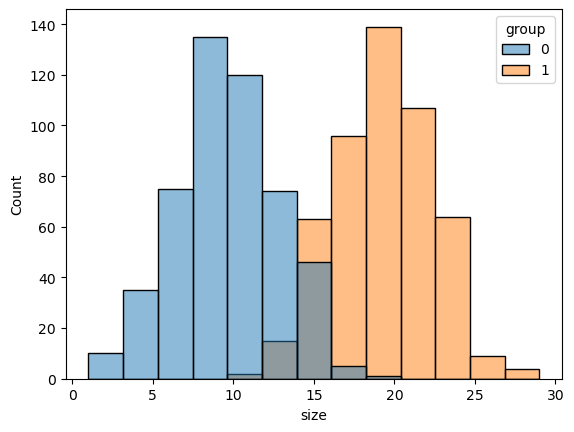

In [16]:
# теперь посмотрим на графике

sns.histplot(data = df_1, x = 'size', hue='group' )
# на графике видно, что количество анкет в 1 группе больше 

In [13]:
# проверим наши предположения статистически
# сравним среднее количество анкет на пользователя в двух группах
# так как сравниваем средние, и распредление на графике у нас выглядит как нормальное
# используем T-test

pg.ttest(x = df_1.query('group==0')['size'], y = df_1.query('group==1')['size'])

# p-val очень маленький, значит различия в средних у нас статистически значимо
# BF10 показывает насколько сильно вероятно, что альтернативная гипотеза верная
# cohen-d - это стандартизованное различие средних в наших группах
# у нас получилось 3.279531 стандартных отклонения, это ощутимое различие
# CI95% так же нам показывает доверительный интервал, относительно первой группы, 
# которую мы указываем, в нашем случае, это контрольная группа
# в нашем случае в контрольной группе было в среднем на 10 анкет меньше чем в эксперимент.

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-51.85607,997.694538,two-sided,2.005369e-285,"[-10.29, -9.54]",3.279531,9.827e+280,1.0


**p-val очень маленький, значит различия в средних у нас CТАТИСТИЧЕСКИ ЗНАЧИМО  
BF10 показывает насколько сильно вероятно, что альтернативная гипотеза верная  
cohen-d - это стандартизованное различие средних в наших группах  
у нас получилось 3.279531 стандартных отклонения, это ощутимое различие  
CI95% так же нам показывает доверительный интервал, относительно первой группы,  
которую мы указываем, в нашем случае, это контрольная группа  
в нашем случае В КОНТРОЛЬНОЙ ГРУППЕ было в среднем на 10 АНКЕТ МЕНЬШЕ чем в тестовой**

### Сравним среднее число мэтчей на каждого пользователя

In [17]:
# выберем только тех пользователей, у кого случился с мэтч
# после этого сгруппируем их по группам и user_id
# и посчитаем количество мэтчей по кадому пользователю,
# через подсчет количество получившихся строк

df_3 = df.query('is_match == 1').groupby(['group', 'user_id_1'], as_index=False).size()
df_3

,group,user_id_1,size
0,0,4,2
1,0,10,3
2,0,12,1
3,0,15,3
4,0,17,1
...,...,...,...
915,1,987,8
916,1,992,8
917,1,993,6
918,1,998,10


<Axes: xlabel='size', ylabel='Count'>

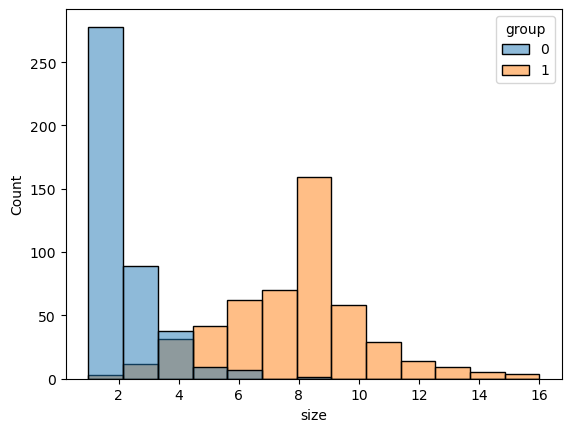

In [19]:
# теперь посмотрим на графике

sns.histplot(data = df_3, x = 'size', hue='group' )

# на графике мы видим, что количество мэтчей в тестовой группе больше чем в контрольной
# так же мы видим, что изменилось среднее
# и изменилось само распределение, в контрольной группе явная ассиметрия

In [24]:
# сделаем сравнение средних через T-test

pg.ttest(x = df_3.query('group==0')['size'], y = df_3.query('group==1')['size'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-45.232978,744.211281,two-sided,9.229585e-216,"[-5.88, -5.39]",2.843535,3.166e+231,1.0


**p-val очень маленький, значит различия в средних у нас CТАТИСТИЧЕСКИ ЗНАЧИМО  
BF10 показывает насколько сильно вероятно, что альтернативная гипотеза верная  
cohen-d - это стандартизованное различие средних в наших группах  
у нас получилось 2.843535 стандартных отклонения, это ощутимое различие  
CI95% так же нам показывает доверительный интервал, относительно первой группы,    
которую мы указываем, в нашем случае, это контрольная группа  
в нашем случае В КОНТРОЛЬНОЙ ГРУППЕ было в среднем на 5 МЭТЧЕЙ НА ЧЕЛОВЕКА МЕНЬШЕ,   
чем в тестовой**

## 3. Ответим на вопрос: Был ли эксперимент успешен в целом и стоит ли включать новую систему поиска анкет на всех пользователей

### Анализируя результаты нашего А/В теста мы видим:

**Пропорция мэтч и не мэтч изменилась, она ВЫРОСЛА В ТЕСТОВОЙ ГРУППЕ и мы получили статистически значимые различия в этой метрике,  
делаю вывод: НОВЫЙ АЛГОРИТМ СТАЛ ЛУЧШЕ ПОДБИРАТЬ АНКЕТЫ ДЛЯ ПОЛЬЗОВАТЕЛЕЙ**

**Среднее число анкет на каждого пользователя так же изменилось, В ТЕСТОВОЙ ГРУППЕ в среднем на 10 АНКЕТ БОЛЬШЕ, чем в контрольной, изменения статистически значимы,
делаю вывод: НОВЫЙ АЛГОРИТМ СТАЛ БОЛЬШЕ ВЫДАВАТЬ АНКЕТ НА КАЖДОГО ПОЛЬЗОВАТЕЛЯ**

**Изменилось и Среднее число мэтчей на каждого пользователя, В ТЕСТОВОЙ ГРУППЕ в среднем на 5 МЭТЧЕЙ БОЛЬШЕ, чем в контрольной, изменения статистически значимы, 
что подтверждает наш вывод: НОВЫЙ АЛГОРИТМ ЛУЧШЕ ПОДБИРАЕТ АНКЕТЫ ДЛЯ ПОЛЬЗОВАТЕЛЕЙ**

## МОЙ ОТВЕТ: БЫЛ ЛИ ЭКСПЕРИМЕНТ УСПЕШЕН В ЦЕЛОМ

### Считаю эксперимент успешным, и вот почему:
**количество уникальных пользователей в обоих группах одинаковое, a колитчество анкет в приложении с новым алгоритмом для поиска анкет ВЫРОСЛО. Новый алгоритм улучшил качество нашего сервиса, пользователи видят в приложении наиболее подходящие им анкеты, ставят друг другу больше лайков, получая мэтч, тем самым у них появляется больше возможности познакомиться, в чем и состоит цель нашего приложения для онлайн-знакомств**

### Рекомендую применить данный эксперимент на всех пользователей приложения.